In [1]:
import numpy as np
import copy
import pandas as pd

import warnings
from muon import prot as pt
warnings.filterwarnings('ignore')
import os
from pathlib import Path
from scipy import sparse
from utils.idk_utils import  find_edges
from Model.Train_and_Predict import get_activity
from utils.Preprocessing import fill_genes
import matplotlib.patches as mpatches


os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

ST_path = '../ST_data'

DGAT_pred_result_path = './data/DGAT_results_reproduction/DGAT_Predicted_ST'
CTP_pred_result_path = './data/DGAT_results_reproduction/CTP-net_Predicted_ST'
scLinear_pred_result_path = './data/DGAT_results_reproduction/scLinear_Predicted_ST'
sciPENN_pred_result_path = './data/DGAT_results_reproduction/sciPENN_Predicted_ST'
Seurat_pred_result_path = './data/DGAT_results_reproduction/Seurat_Predicted_ST'

with open("../common_gene_11535.txt", "r") as f: 
    common_gene = [line.strip() for line in f]

with open("../common_protein_31.txt", "r") as f: 
    common_protein = [line.strip() for line in f]
    
seed = 2025

np.random.seed(seed)



### LN

In [2]:
sample_name = 'LN'

In [3]:
import tarfile
if not hasattr(tarfile, 'data_filter'):
    tarfile.data_filter = None 

import scanpy as sc
adata_LN = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_LN.var_names_make_unique()
celltypes = pd.read_csv("../resources/W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("../resources/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)
obs_names = np.intersect1d(celltypes.index, adata_LN.obs_names)
adata_LN = adata_LN[obs_names]
celltypes = celltypes.loc[obs_names]
gc_annotation = gc_annotation.loc[obs_names]
adata_LN.obsm['celltype'] = celltypes
adata_LN.obsm['celltype'].columns = [x.replace('mean_spot_factors','') for x in adata_LN.obsm['celltype'].columns]
adata_LN.obsm['celltype_raw'] = adata_LN.obsm['celltype'].copy()
adata_LN.obsm['celltype'] = adata_LN.obsm['celltype'].divide(adata_LN.obsm['celltype'].sum(axis=1), axis=0)
adata_LN.obs['germinal_center'] = gc_annotation
adata_LN.obs['germinal_center'] = adata_LN.obs['germinal_center'].map({0: "Other", 1: "GC"})

In [4]:
DGAT_LN_pdata = sc.read_h5ad(f'{DGAT_pred_result_path}/{sample_name}.h5ad')

In [5]:
CTP_LN_pdata = sc.read_h5ad(f'{CTP_pred_result_path}/{sample_name}.h5ad')

In [6]:
scLinear_LN_pdata = sc.read_h5ad(f'{scLinear_pred_result_path}/{sample_name}.h5ad')

In [7]:
sciPENN_LN_pdata = sc.read_h5ad(f'{sciPENN_pred_result_path}/{sample_name}.h5ad')

In [8]:
Seurat_ADT_count = pd.read_csv(f'{Seurat_pred_result_path}/{sample_name}.csv').T
new_columns = Seurat_ADT_count.iloc[0].tolist()

Seurat_ADT_count = Seurat_ADT_count.iloc[1:]
Seurat_ADT_count.columns = [column.replace('-','_') for column in new_columns]
Seurat_LN_pdata = adata_LN.copy()
Seurat_LN_pdata.obsm['ADT'] = Seurat_ADT_count
Seurat_LN_pdata = get_activity(Seurat_LN_pdata,key = 'ADT')

In [9]:
sc.pp.filter_cells(adata_LN, min_genes=700)
sc.pp.normalize_total(adata_LN, target_sum=1e4)
sc.pp.log1p(adata_LN)
sc.pp.scale(adata_LN, max_value=10)

adata_LN = fill_genes(adata_LN,common_gene)


Sample lost 0 genes, 11535 in total


In [10]:
points, edges = find_edges(adata_LN)

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt
import random
from matplotlib.gridspec import GridSpec
from sklearn.metrics import f1_score
def plot_leiden_side_by_side(
    
    adata_list,
    palette_list = None,
    method_list = None,
    points = None,edges = None,
    color_key='leiden',
    n_neighbors=10,
    resolution_list=[0.5,0.5],
    size=1.7,
    palette='tab20',
    figsize=(25, 5),
    title = '',
    true_label_key='germinal_center',
    true_label_value='GC',
    save_fig = False,
    gc_list=None
):
    for i,ad in enumerate(adata_list):
        sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep='X')
        sc.tl.leiden(ad, resolution=resolution_list[i])

    fig, axes = plt.subplots(1, len(adata_list)+1, figsize=figsize, squeeze=False)
    axes = axes[0]


    sc.pl.spatial(adata_list[0], ax=axes[0], show=False, frameon=False)
    if points is not None and edges is not None:
        for ii, jj in edges:
            axes[0].plot(points[[ii, jj], 0],
                         points[[ii, jj], 1],
                         color='red', linewidth=1)

    for i, adata in enumerate(adata_list):
        if not i==len(adata_list)-1:
            sc.pl.spatial(
                adata_list[i], color=color_key, size=size, palette=palette_list[i],
                frameon=False, ax=axes[i+1], show=False, legend_loc=None,
                title=method_list[i]
            )
        else:
            sc.pl.spatial(
                adata_list[i], color=color_key, size=size, palette=palette_list[i],
                frameon=False, ax=axes[i+1], show=False,
                title=method_list[i]
            )
            if axes[i+1].get_legend() is not None:
                #print('11')
                for text in axes[i+1].get_legend().get_texts():
                    text.set_fontsize(20) 
                    
        if points is not None and edges is not None:
            for ii, jj in edges:
                axes[i+1].plot(points[[ii, jj], 0],
                             points[[ii, jj], 1],
                             'k-', linewidth=1)

        if true_label_key in adata.obs and gc_list is not None:
            best_score = 0
            for idx in adata.obs['leiden'].unique():
                pred = (adata.obs['leiden'] == f"{idx}").astype(int)
                true = (adata.obs[true_label_key] == true_label_value).astype(int)
                f1 = f1_score(true, pred)
                if f1>best_score:
                    best_score = f1
            axes[i+1].text(
                0.02, 0.02, f"F1: {best_score:.3f}", transform=axes[i+1].transAxes,
                fontsize=14, color='black', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
            )

    for ax in axes:
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel(''); ax.set_ylabel('')

    plt.tight_layout(rect=(0, 0, 0.85, 1))  
    if save_fig:
        plt.savefig('./' + title + '_all_method_new.pdf', bbox_inches='tight', dpi = 300)
    plt.show()



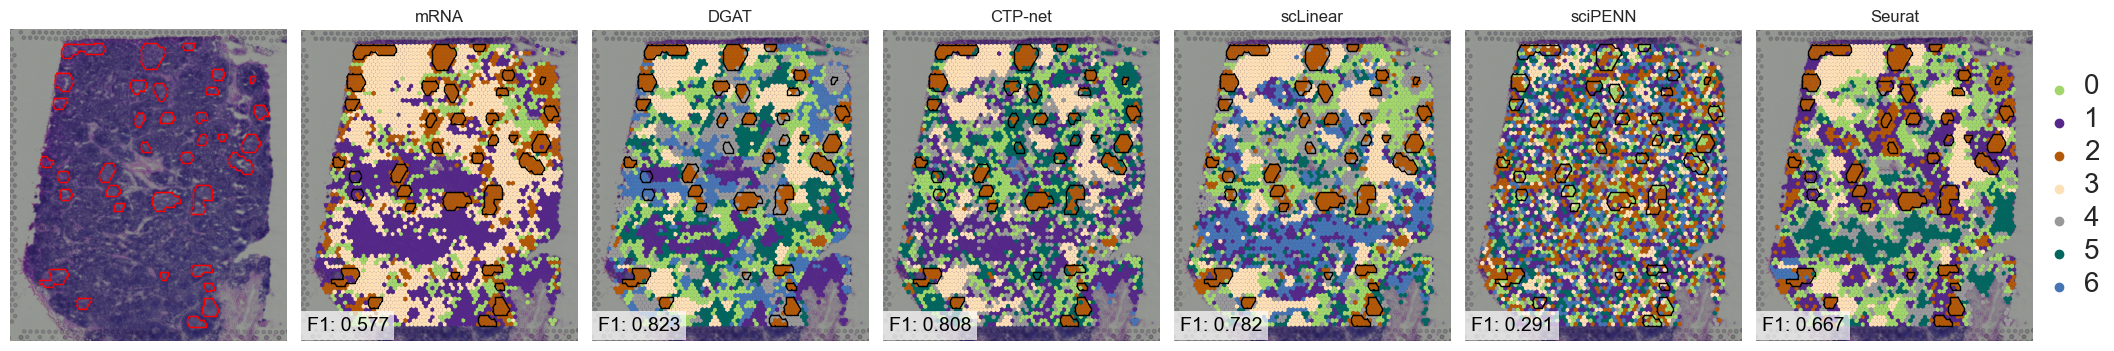

In [12]:
gc_list = [2,6,6,4,0,2]

colors = [
    (254/255, 224/255, 182/255),  # #fee0b6 
    (179/255,  88/255,   6/255),  # #b35806 
    (153/255, 153/255, 153/255),  # #999999 
    (161/255, 215/255, 106/255),  # #a1d76a 
    ( 69/255, 117/255, 180/255),  # #4575b4 
    ( 84/255,  39/255, 136/255),  # #542788 
    (  1/255, 102/255,  94/255),   # #01665e 
     
]

order_list = [[0,5,1,3,2,6,4],[3,6,2,4,0,5,1],[5,6,2,3,0,1,4],[0,3,2,4,1,5,6],[1,5,4,3,0,6,2],[3,5,1,0,2,6,4]]

palette_list = [[colors[i] for i in order] for order in order_list]


LN_list = [adata_LN,DGAT_LN_pdata,CTP_LN_pdata,scLinear_LN_pdata,sciPENN_LN_pdata,Seurat_LN_pdata]
plot_leiden_side_by_side(LN_list, palette_list  = palette_list, method_list = ['mRNA','DGAT','CTP-net','scLinear','sciPENN','Seurat'], points = points,edges=edges,n_neighbors = 10,resolution_list = [1.09,0.43,0.49,0.54, 0.58, 0.09],title = 'Lymph_Node_Leiden',save_fig  = True, gc_list = gc_list)




### TNBC

In [13]:
method_list = ['DGAT','CTP-net','scLinear','sciPENN','Seurat','mRNA']

In [14]:
sample_name = 'CID44971'

In [15]:
adata_4471 = sc.read_h5ad(f'{ST_path}/{sample_name}.h5ad')

DGAT_44971_pdata = sc.read_h5ad(f'{DGAT_pred_result_path}/{sample_name}.h5ad')
CTP_44971_pdata = sc.read_h5ad(f'{CTP_pred_result_path}/{sample_name}.h5ad')
scLinear_44971_pdata = sc.read_h5ad(f'{scLinear_pred_result_path}/{sample_name}.h5ad')
sciPENN_44971_pdata = sc.read_h5ad(f'{sciPENN_pred_result_path}/{sample_name}.h5ad')

Seurat_ADT_count = pd.read_csv(f'{Seurat_pred_result_path}/{sample_name}.csv').T
new_columns = Seurat_ADT_count.iloc[0].tolist()

Seurat_ADT_count = Seurat_ADT_count.iloc[1:]
Seurat_ADT_count.columns = [column.replace('-','_') for column in new_columns]
Seurat_44971_pdata = adata_4471.copy()
Seurat_44971_pdata.obsm['ADT'] = Seurat_ADT_count
Seurat_44971_pdata = get_activity(Seurat_44971_pdata,key = 'ADT')


In [16]:
sc.pp.filter_cells(adata_4471, min_genes=700)
adata_4471 = adata_4471.copy()

adata_4471 = fill_genes(adata_4471,common_gene)

sc.pp.normalize_total(adata_4471, target_sum=1e4)
sc.pp.log1p(adata_4471)
sc.pp.scale(adata_4471, max_value=10)

Sample lost 161 genes, 11535 in total


In [17]:
Breast_list=[DGAT_44971_pdata,CTP_44971_pdata,scLinear_44971_pdata,sciPENN_44971_pdata,Seurat_44971_pdata,adata_4471]

In [18]:
from sklearn.metrics import adjusted_rand_score

def compute_ari_from_anndata(adata, true_label_key='Pathology', pred_label_key='leiden', None_anno_c=None):
    label_counts = adata.obs[true_label_key].value_counts()
    valid_labels = label_counts[label_counts >= 5].index
    adata = adata[adata.obs[true_label_key].isin(valid_labels)].copy()

    if None_anno_c:
        new_adata = adata[adata.obs[true_label_key] != None_anno_c, :].copy()
    else:
        new_adata = adata.copy()

    mask = (
        new_adata.obs[true_label_key].notna() &
        new_adata.obs[pred_label_key].notna()
    )
    new_adata = new_adata[mask, :].copy()
    #print(new_adata)

    true_labels = new_adata.obs[true_label_key].values
    pred_labels = new_adata.obs[pred_label_key].values

    ari = adjusted_rand_score(true_labels, pred_labels)
    return ari    

def plot_leiden_ARI(
    adata_list,
    palette_list=None,
    method_list=None,
    color_key='leiden',

    n_neighbors=10,
    resolution_list=None,
    size=1.7,
    palette='tab20',
    title='',
    save_fig=False,
    pred_label_key = 'leiden',
    true_label_key = 'Pathology',
    ref_color = 'tab20',
    #None_anno_c
):


    if resolution_list is None:
        resolution_list = [0.5] * len(adata_list)

    for i, ad in enumerate(adata_list):

        sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep='X')
        sc.tl.leiden(ad, resolution=resolution_list[i])

    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.2], figure=fig)

    ax0 = fig.add_subplot(gs[0, 0])
    sc.pl.spatial(
        adata_list[-1],
        ax=ax0,
        color=true_label_key,
        show=False,
        frameon=False,
        size=size,
        palette='Set2',#ref_color,
        legend_loc=None,
    )
    ax0.set_xticks([]); ax0.set_yticks([]); ax0.set_xlabel(''); ax0.set_ylabel('')
    ax0.set_title("Reference", fontsize=16)

    ax0_legend = fig.add_subplot(gs[1, 0])
    ax0_legend.axis('off')
    ref_labels = adata_list[-1].obs[true_label_key].dropna().astype(str).unique()

  # ref_labels = sorted(adata_list[-1].obs[true_label_key].unique())
    ref_colors = plt.get_cmap('Set2').colors[:len(ref_labels)]
    patches = [mpatches.Patch(color=c, label=str(l)) for c,l in zip(ref_colors, ref_labels)]
    ax0_legend.legend(patches, [str(l) for l in ref_labels],
                      loc='upper left', fontsize=14, frameon=False)
    #cb.set_label(true_label_key, fontsize=14)

    for idx, adata in enumerate(adata_list):
        row = idx % 2
        col = idx // 2 + 1  
        ax = fig.add_subplot(gs[row, col])

        sc.pl.spatial(
            adata,
            color=color_key,
            size=size,
            palette=palette_list[idx],
            frameon=False,
            ax=ax,
            show=False,
            title=method_list[idx],
            legend_loc=None,
        )

        # 构造 legend
        if idx == len(adata_list) - 1:
            leiden_labels = sorted(adata.obs[color_key].unique(), key=lambda x: int(x))
            colors = palette_list[idx][:len(leiden_labels)]
            legend_handles = [
                mpatches.Patch(color=col, label=str(lab)) for col, lab in zip(colors, leiden_labels)
            ]
            legend_labels = [str(lab) for lab in leiden_labels]

        if true_label_key in adata.obs:
            ari_score = compute_ari_from_anndata(adata, true_label_key=true_label_key, pred_label_key=color_key, None_anno_c = 'Unannotated')
            ax.text(
                0.02, 0.02, f"ARI: {ari_score:.3f}", transform=ax.transAxes,
                fontsize=20, color='black', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
            )

        ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')

    # 最右侧 legend
    if legend_handles is not None:
        ax_legend = fig.add_subplot(gs[:, -1])
        ax_legend.axis('off')
        ax_legend.legend(
            legend_handles,
            legend_labels,
            loc='center',
            fontsize=16,
            #title=color_key,
            title_fontsize=16,
            frameon=False
        )

    # 控制间距（不使用 tight_layout）
    fig.subplots_adjust(
        left=0.01,
        right=0.98,
        bottom=0.05,
        top=0.95,
        wspace=0.15,
        hspace=0.18
    )

    if save_fig:
        plt.savefig(f'./{title}_6methods_hardcoded_ARI.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [19]:

ref_order = [0,4,5,2,3,1]
order_list = [[0,4,5,1,3,2],[0,1,3,5,4,2],[0,5,2,3,1,4],[1,5,4,3,0,2],[1,5,3,0,4,2],[0,4,5,1,2,3]]

palette_list = [[colors[i] for i in order] for order in order_list]
ref_color = [colors[i] for i in ref_order]

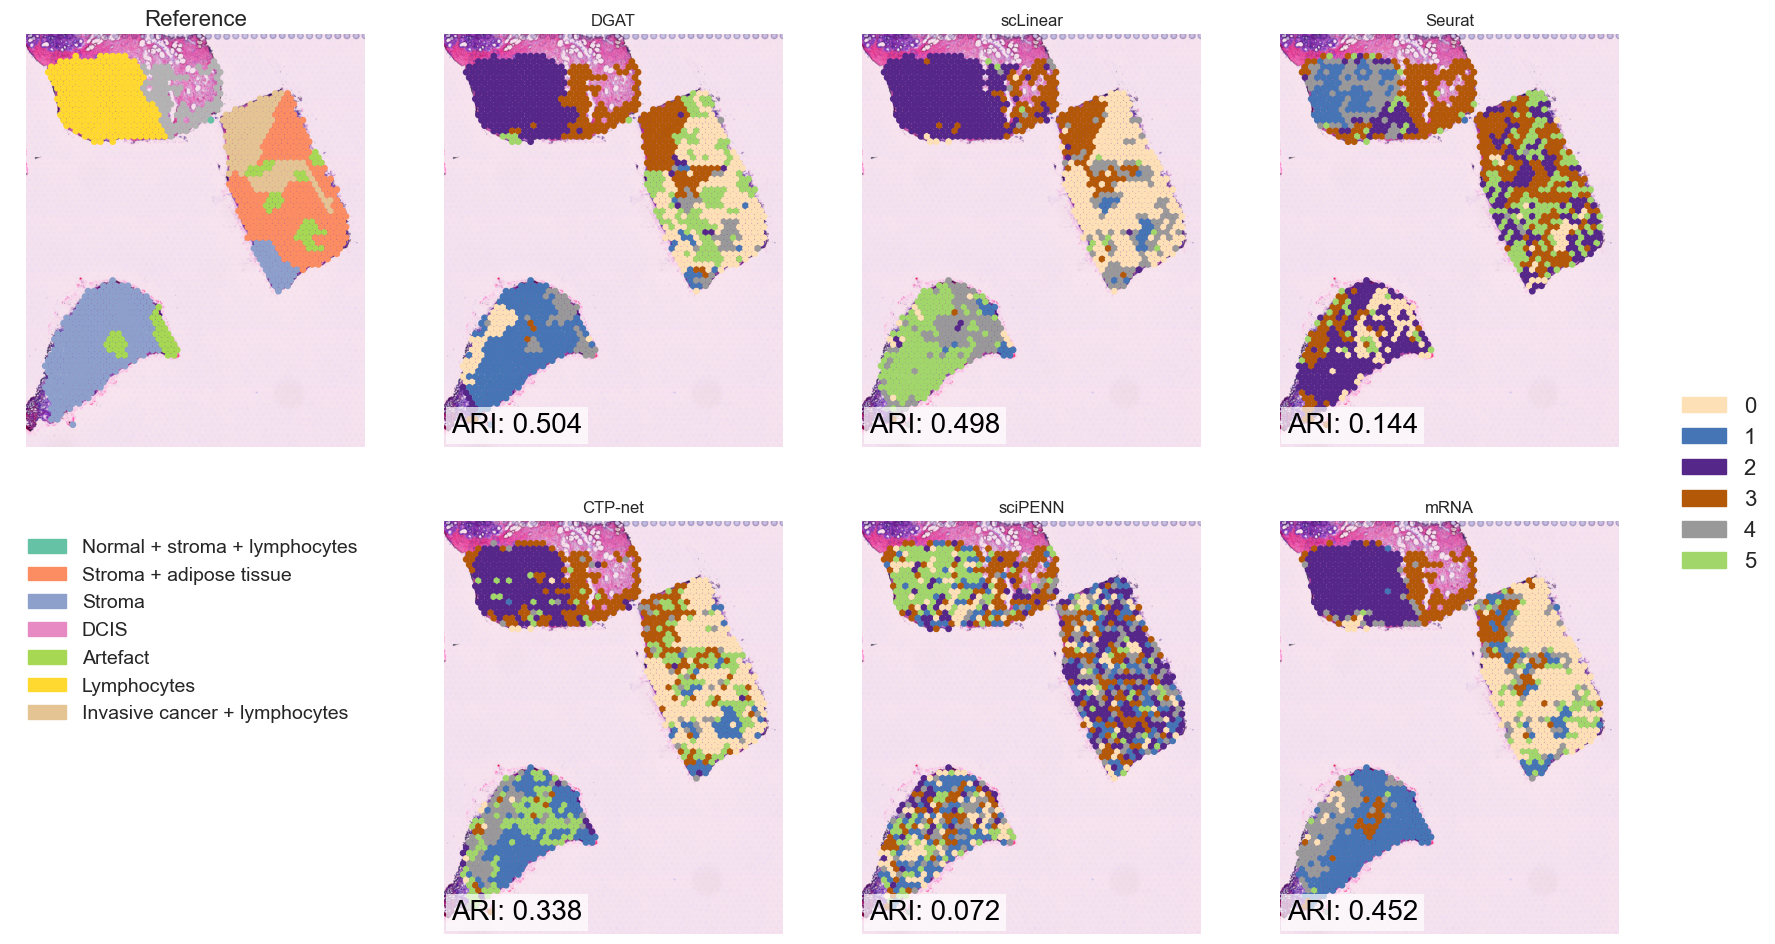

In [20]:
plot_leiden_ARI(
    Breast_list,
    palette_list=palette_list,
    method_list=method_list,
    color_key='leiden',
    n_neighbors=10,
    resolution_list=[0.45, 0.48, 0.5, 0.5, 0.08 ,1.37],
    size=1.7,
    #palette='tab20',
    title='Breast',
    save_fig=True,
    pred_label_key = 'leiden',
    true_label_key = 'pathology',
    ref_color = ref_color,
    
)


### Melanoma

In [21]:
sample_name = 'Melanoma'

In [22]:
adata_Mela = sc.read_h5ad(f'{ST_path}/{sample_name}.h5ad')

DGAT_Melanoma_pdata = sc.read_h5ad(f'{DGAT_pred_result_path}/{sample_name}.h5ad')
CTP_Melanoma_pdata = sc.read_h5ad(f'{CTP_pred_result_path}/{sample_name}.h5ad')
scLinear_Melanoma_pdata = sc.read_h5ad(f'{scLinear_pred_result_path}/{sample_name}.h5ad')
sciPENN_Melanoma_pdata = sc.read_h5ad(f'{sciPENN_pred_result_path}/{sample_name}.h5ad')

Seurat_ADT_count = pd.read_csv(f'{Seurat_pred_result_path}/{sample_name}.csv').T
new_columns = Seurat_ADT_count.iloc[0].tolist()

Seurat_ADT_count = Seurat_ADT_count.iloc[1:]
Seurat_ADT_count.columns = [column.replace('-','_') for column in new_columns]
Seurat_Melanoma_pdata = adata_Mela.copy()
Seurat_Melanoma_pdata.obsm['ADT'] = Seurat_ADT_count
Seurat_Melanoma_pdata = get_activity(Seurat_Melanoma_pdata,key = 'ADT')

Melanoma_list = [DGAT_Melanoma_pdata,CTP_Melanoma_pdata,scLinear_Melanoma_pdata,sciPENN_Melanoma_pdata,Seurat_Melanoma_pdata]
for i in range(len(Melanoma_list)):
    Melanoma_list[i].obs['annotation'] = adata_Mela[Melanoma_list[i].obs_names,:].obs['annotation'].copy()

sc.pp.filter_cells(adata_Mela, min_genes=700)

adata_Mela = fill_genes(adata_Mela,common_gene)

sc.pp.normalize_total(adata_Mela, target_sum=1e4)
sc.pp.log1p(adata_Mela)
sc.pp.scale(adata_Mela, max_value=10)

Melanoma_list.append(adata_Mela)

Sample lost 756 genes, 11535 in total


In [23]:
def plot_leiden_ARI_scatter_n(
    adata_list,
    palette_list=None,
    method_list=None,
    color_key='leiden',
    n_neighbors=10,
    resolution_list=None,
    size=1.7,
    palette='tab20',
    title='',
    save_fig=False,
    pred_label_key='leiden',
    true_label_key='Pathology',
    ref_color='Set2',
    gc_list=None,
    test=False,
    figsize=(21, 10),
    dot_size=100,
    None_anno_c=None
):



    if resolution_list is None:
        resolution_list = [0.5] * len(adata_list)

    for i, ad in enumerate(adata_list):
        sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep='X')
        sc.tl.leiden(ad, resolution=resolution_list[i])

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.2], figure=fig)

    ax0 = fig.add_subplot(gs[0, 0])
    coords = adata_list[-1].obsm['spatial']
    labels = adata_list[-1].obs[true_label_key]
    unique_labels = sorted(labels.unique())

    cmap_ref = plt.get_cmap('Set2')
    ref_colors = cmap_ref.colors[:len(unique_labels)]

    for label, color in zip(unique_labels, ref_colors):
        mask = (labels == label).values
        cluster_coords = coords[mask]
        if cluster_coords.size == 0:
            continue
        ax0.scatter(
            cluster_coords[:, 0], cluster_coords[:, 1],
            color=color, label=str(label),
            s=dot_size, alpha=0.9
        )
    ax0.set_title('Reference', fontsize=20)
    ax0.axis('equal')
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.axis('off')

    ax0_legend = fig.add_subplot(gs[1, 0])
    ax0_legend.axis('off')
    ref_handles = [mpatches.Patch(color=col, label=str(lab))
                   for col, lab in zip(ref_colors, unique_labels)]
    ax0_legend.legend(
        handles=ref_handles,
        labels=[str(lab) for lab in unique_labels],
        loc='center',
        fontsize=14,
        frameon=False,
        ncol=1
    )

    legend_handles = None
    legend_labels = None
    for idx, adata in enumerate(adata_list):
        row = idx % 2
        col = idx // 2 + 1
        ax = fig.add_subplot(gs[row, col])

        coords = adata.obsm['spatial']
        if color_key not in adata.obs:
            continue
        adata.obs[color_key] = adata.obs[color_key].astype('category')
        leiden_cats = adata.obs[color_key].cat.categories.tolist()
        pal = (palette_list[idx] if palette_list is not None
               else plt.get_cmap(palette).colors)

        for i, lbl in enumerate(leiden_cats):
            mask = (adata.obs[color_key] == lbl).values
            ax.scatter(
                coords[mask, 0], coords[mask, 1] * -1,
                s=dot_size, alpha=0.8,
                color=pal[i % len(pal)],
                label=str(lbl)
            )
        ax.set_title(method_list[idx] if method_list else f'Method {idx+1}',fontsize = 20)
        ax.axis('off')
        ax.invert_yaxis()

        ari_score = compute_ari_from_anndata(
            adata, true_label_key=true_label_key,
            pred_label_key=color_key,
            None_anno_c=None_anno_c
        )
        ax.text(
            0.02, 0.02, f'ARI: {ari_score:.3f}',
            transform=ax.transAxes,
            fontsize=20, color='black',
            ha='left', va='bottom',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )

        if test:
            small_handles = [mpatches.Patch(color=pal[i % len(pal)], label=str(lbl))
                             for i, lbl in enumerate(leiden_cats)]
            ax.legend(
                handles=small_handles,
                labels=[str(lbl) for lbl in leiden_cats],
                loc='lower right', fontsize=8,
                frameon=False
            )

        if idx == len(adata_list) - 1:
            legend_handles = [mpatches.Patch(color=pal[i % len(pal)], label=str(lbl))
                              for i, lbl in enumerate(leiden_cats)]
            legend_labels = [str(lbl) for lbl in leiden_cats]

    if legend_handles:
        ax_legend = fig.add_subplot(gs[:, -1])
        ax_legend.axis('off')
        ax_legend.legend(
            handles=legend_handles,
            labels=legend_labels,
            loc='center',
            fontsize=12,
            title=color_key,
            title_fontsize=12,
            frameon=False
        )

    fig.subplots_adjust(
        left=0.01, right=0.98,
        bottom=0.05, top=0.95,
        wspace=0.15, hspace=0.18
    )

    if save_fig:
        plt.savefig(f'./{title}_6methods_scatter_ARI.pdf', bbox_inches='tight', dpi=300)
    plt.show()


In [24]:
colors = [
    (254/255, 224/255, 182/255),  # #fee0b6 粉橙
    (179/255,  88/255,   6/255),  # #b35806 深橘棕
    (153/255, 153/255, 153/255),  # #999999 灰色
    #(161/255, 215/255, 106/255),  # #a1d76a 草绿
    ( 69/255, 117/255, 180/255),  # #4575b4 蓝色
    ( 84/255,  39/255, 136/255),  # #542788 深紫
    (  1/255, 102/255,  94/255),   # #01665e 深蓝绿
    (161/255, 215/255, 106/255),
]
ref_order = [4,0,3,1]
order_list = [[4,1,0,3],[0,4,1,3],[4,1,3,0],[4,0,3,1],[0,4,3,1],[0,4,3,1]]



palette_list = [[colors[i] for i in order] for order in order_list]
ref_color = [colors[i] for i in ref_order]

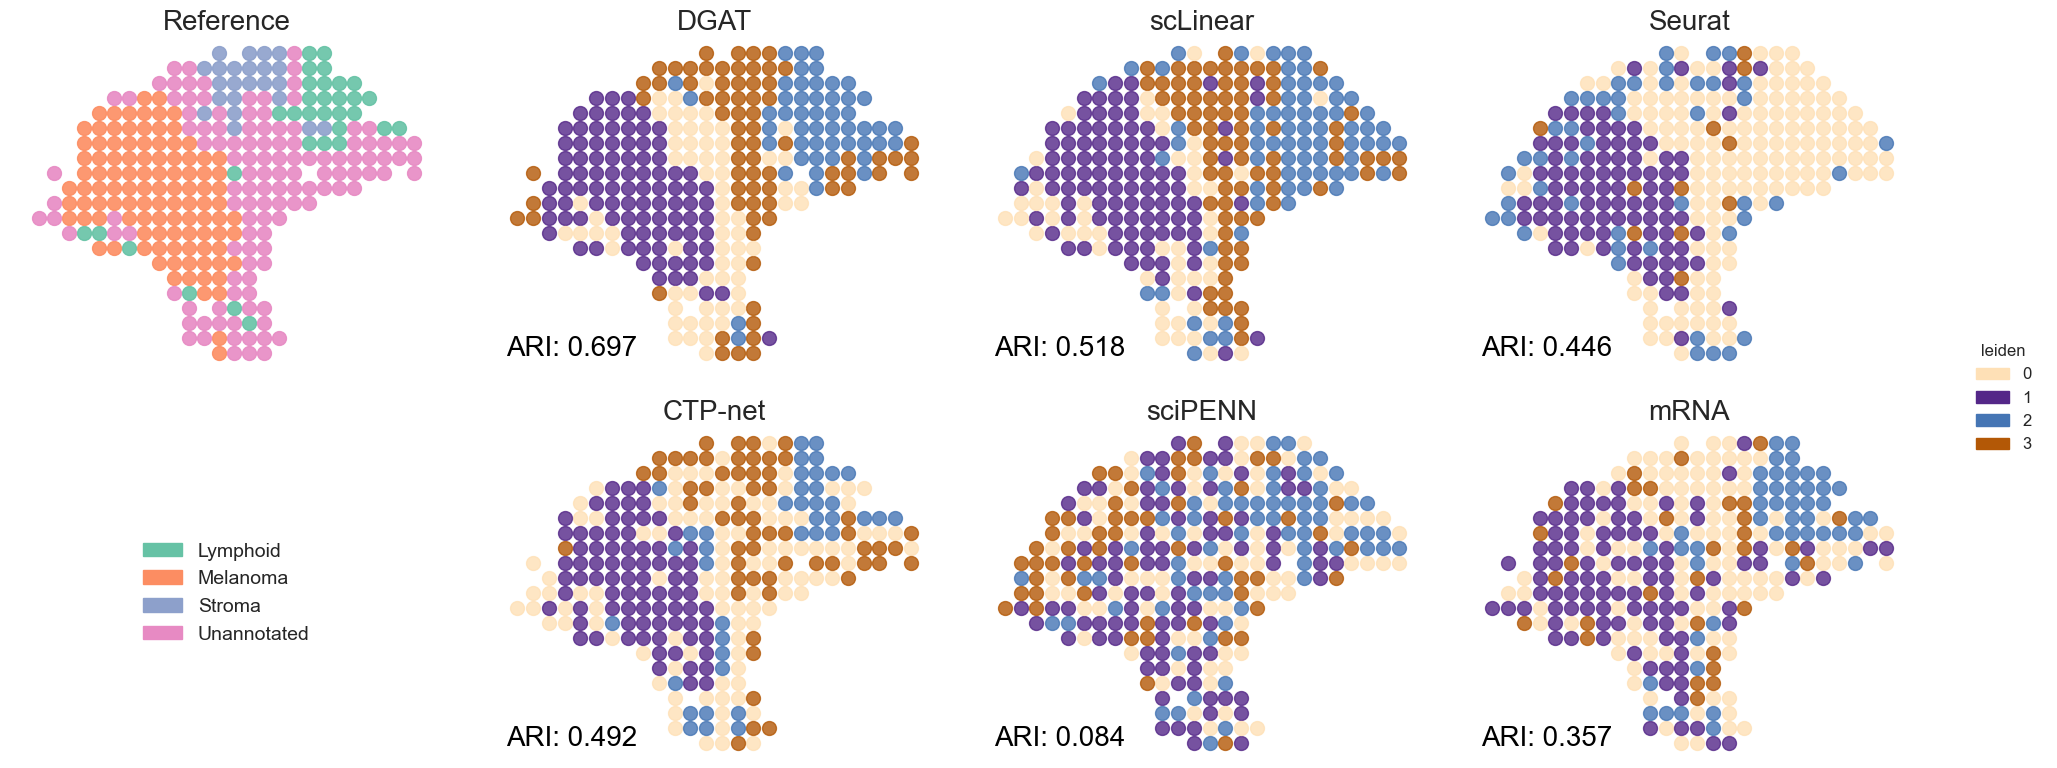

In [25]:
plot_leiden_ARI_scatter_n(
    Melanoma_list,
    palette_list=palette_list,
    method_list=method_list,
    color_key='leiden',
    n_neighbors=10,
    resolution_list=[0.42, 0.25, 0.48, 0.45, 0.002 ,0.98],
    size=1.7,
    #palette='tab20',
    title='Melanoma',
    save_fig=True,
    pred_label_key = 'leiden',
    true_label_key = 'annotation',
    ref_color = ref_color,
    #test = True,
    figsize=(21, 8),
    None_anno_c = 'Unannotated'
    
)

### iImpact Prostate

In [26]:
sample_name = 'Prostate'

In [27]:
adata_Prostate = sc.read_h5ad(f'{ST_path}/{sample_name}.h5ad')


DGAT_Prostate_pdata = sc.read_h5ad(f'{DGAT_pred_result_path}/{sample_name}.h5ad')
CTP_Prostate_pdata = sc.read_h5ad(f'{CTP_pred_result_path}/{sample_name}.h5ad')
scLinear_Prostate_pdata = sc.read_h5ad(f'{scLinear_pred_result_path}/{sample_name}.h5ad')
sciPENN_Prostate_pdata = sc.read_h5ad(f'{sciPENN_pred_result_path}/{sample_name}.h5ad')
Seurat_ADT_count = pd.read_csv(f'{Seurat_pred_result_path}/{sample_name}.csv').T

new_columns = Seurat_ADT_count.iloc[0].tolist()

Seurat_ADT_count = Seurat_ADT_count.iloc[1:]
Seurat_ADT_count.columns = [column.replace('-','_') for column in new_columns]
Seurat_Prostate_pdata = adata_Prostate.copy()
Seurat_Prostate_pdata.obsm['ADT'] = Seurat_ADT_count
Seurat_Prostate_pdata = get_activity(Seurat_Prostate_pdata,key = 'ADT')

sc.pp.filter_cells(adata_Prostate, min_genes=700)


adata_Prostate.var_names = [var.split(' ')[0] for var in adata_Prostate.var_names]

adata_Prostate = fill_genes(adata_Prostate,common_gene)

sc.pp.normalize_total(adata_Prostate, target_sum=1e4)
sc.pp.log1p(adata_Prostate)
sc.pp.scale(adata_Prostate, max_value=10)



Sample lost 393 genes, 11535 in total


In [28]:
Prostate_list = [DGAT_Prostate_pdata,CTP_Prostate_pdata,scLinear_Prostate_pdata,sciPENN_Prostate_pdata,Seurat_Prostate_pdata,adata_Prostate]

In [29]:
Prostate_list

[AnnData object with n_obs × n_vars = 4368 × 31
     obs: 'x', 'y', 'annotation', 'n_genes', 'leiden'
     uns: 'leiden', 'log1p', 'name', 'neighbors'
     obsm: 'X_spatial', 'spatial'
     layers: 'protein_predict'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 4368 × 31
     obs: 'x', 'y', 'annotation', 'n_genes', 'leiden'
     uns: 'leiden', 'neighbors'
     obsm: 'X_spatial', 'spatial'
     layers: 'protein_predict'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 4371 × 31
     obs: 'x', 'y', 'annotation', 'leiden'
     uns: 'leiden', 'neighbors'
     obsm: 'X_spatial', 'spatial'
     layers: 'scLinear_predicted'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 4370 × 31
     obs: 'x', 'y', 'annotation', 'batch', 'leiden'
     uns: 'leiden', 'neighbors'
     obsm: 'X_spatial', 'spatial'
     layers: 'protein_predict'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × 

In [30]:

ref_order = [4,1,3,0]
order_list = [[1,4,3,0],[4,0,1,3],[4,1,3,0],[3,0,4,1],[4,3,1,0],[1,3,4,0]]



palette_list = [[colors[i] for i in order] for order in order_list]
ref_color = [colors[i] for i in ref_order]

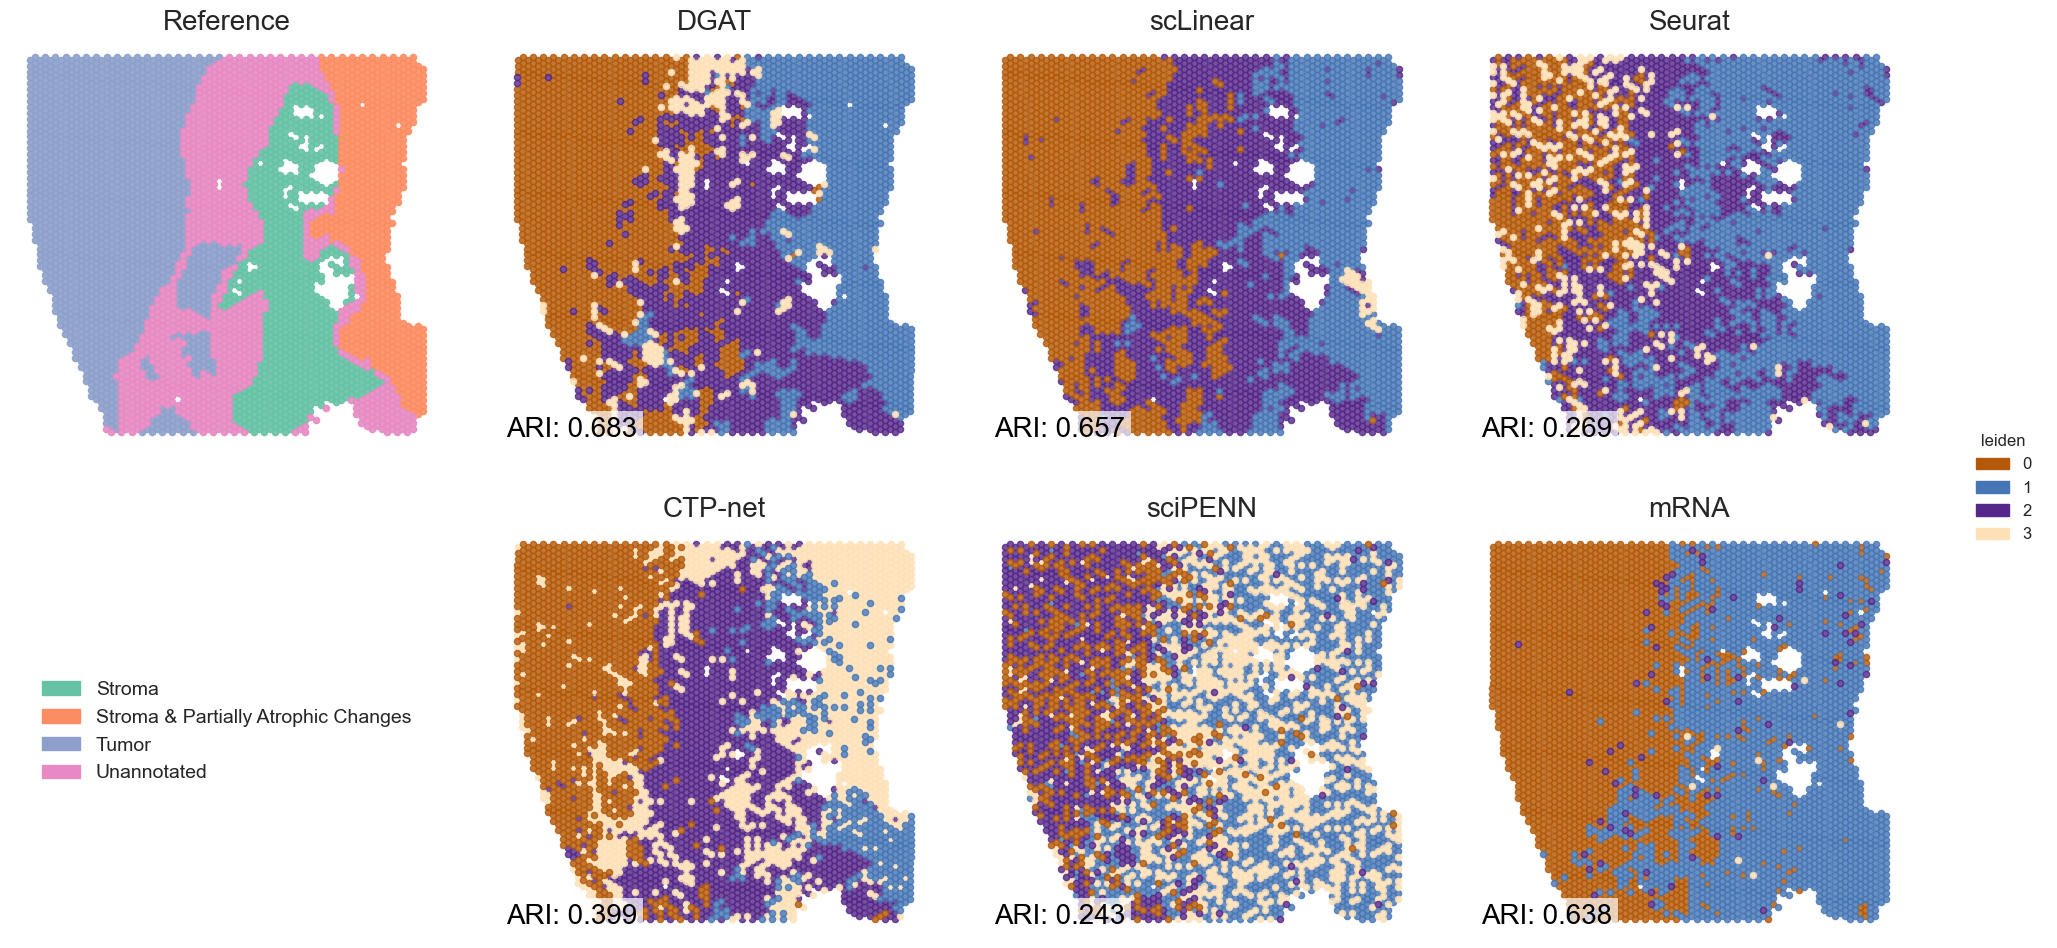

In [31]:
plot_leiden_ARI_scatter_n(
    Prostate_list,
    palette_list=palette_list,
    method_list=method_list,
    color_key='leiden',
    n_neighbors=10,
    resolution_list=[0.251, 0.15, 0.25, 0.34, 0.034,1],
    size=1.7,
    #palette='tab20',
    title='Prostate',
    save_fig=True,
    pred_label_key = 'leiden',
    true_label_key = 'annotation',
    ref_color = ref_color,
    None_anno_c = 'Unannotated',
    #test = True,
    figsize=(21, 10),
    dot_size = 20
    
)

### iImpact Breast

In [32]:
sample_name ='Breast'

In [33]:
adata_i_Breast = sc.read_h5ad(f'{ST_path}/{sample_name}.h5ad')

DGAT_i_Breast_pdata = sc.read_h5ad(f'{DGAT_pred_result_path}/{sample_name}.h5ad')
CTP_i_Breast_pdata = sc.read_h5ad(f'{CTP_pred_result_path}/{sample_name}.h5ad')
scLinear_i_Breast_pdata = sc.read_h5ad(f'{scLinear_pred_result_path}/{sample_name}.h5ad')
sciPENN_i_Breast_pdata = sc.read_h5ad(f'{sciPENN_pred_result_path}/{sample_name}.h5ad')

Seurat_ADT_count = pd.read_csv(f'{Seurat_pred_result_path}/{sample_name}.csv').T
new_columns = Seurat_ADT_count.iloc[0].tolist()

Seurat_ADT_count = Seurat_ADT_count.iloc[1:]
Seurat_ADT_count.columns = [column.replace('-','_') for column in new_columns]
Seurat_i_Breast_pdata = adata_i_Breast.copy()
Seurat_i_Breast_pdata.obsm['ADT'] = Seurat_ADT_count
Seurat_i_Breast_pdata = get_activity(Seurat_i_Breast_pdata,key = 'ADT')

sc.pp.filter_cells(adata_i_Breast, min_genes=700)
adata_i_Breast = adata_i_Breast.copy()

adata_i_Breast.var_names = [var.split(' ')[0] for var in adata_i_Breast.var_names]

adata_i_Breast = fill_genes(adata_i_Breast,common_gene)

sc.pp.normalize_total(adata_i_Breast, target_sum=1e4)
sc.pp.log1p(adata_i_Breast)
sc.pp.scale(adata_i_Breast, max_value=10)

Sample lost 393 genes, 11535 in total


In [34]:
i_Breast_list = [DGAT_i_Breast_pdata,CTP_i_Breast_pdata,scLinear_i_Breast_pdata,sciPENN_i_Breast_pdata,Seurat_i_Breast_pdata,adata_i_Breast]

In [35]:

ref_order = [0,2,3,4,5,1]
order_list = [[4,2,1,3,5,0],[2,4,5,1,3,0],[2,4,0,1,3,5],[1,5,4,3,0,2],[2,5,3,0,1,4],[1,0,4,2,3,5]]

palette_list = [[colors[i] for i in order] for order in order_list]
ref_color = [colors[i] for i in ref_order]

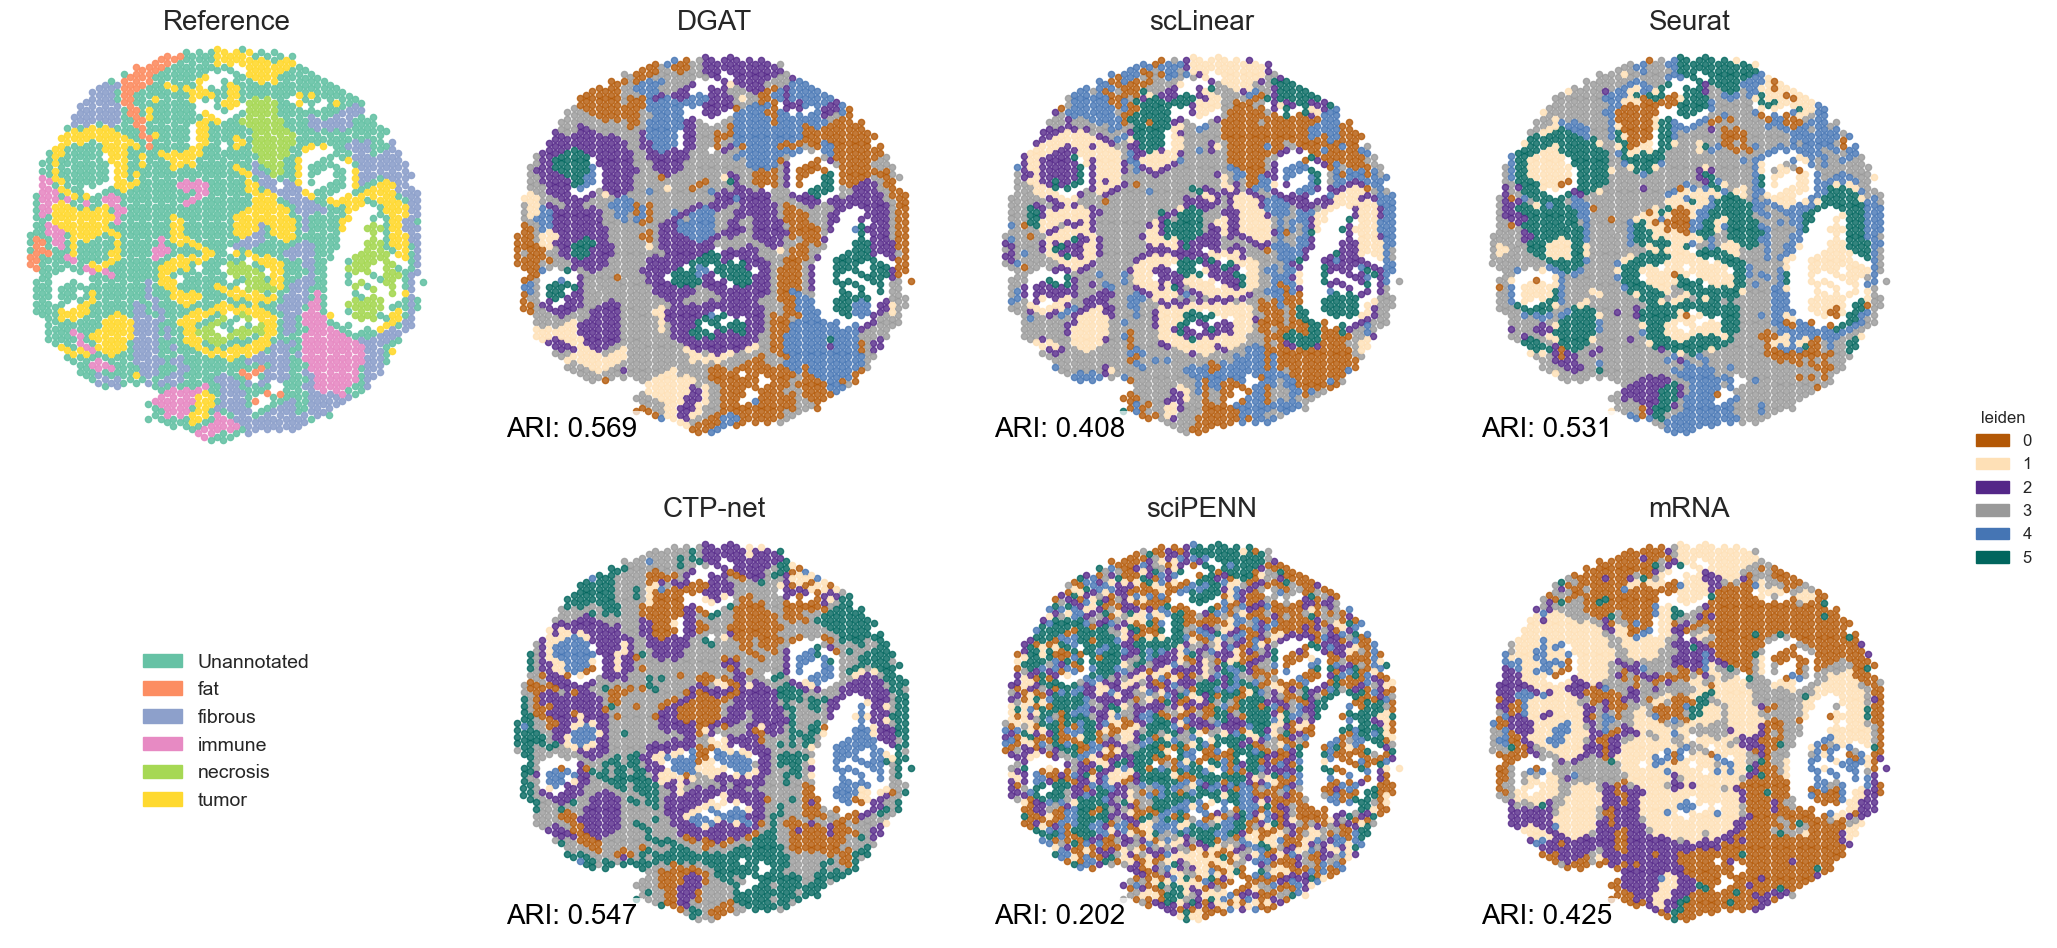

In [36]:
plot_leiden_ARI_scatter_n(
    i_Breast_list,
    palette_list=palette_list,
    method_list=method_list,
    color_key='leiden',
    n_neighbors=10,
    resolution_list=[0.318, 0.18, 0.3, 0.45, 0.05,1.1],
    size=1.7,
    #palette='tab20',
    title='iImpact Breast',
    save_fig=True,
    pred_label_key = 'leiden',
    true_label_key = 'annotation',
    None_anno_c = 'Unannotated',
    ref_color = ref_color,
    #test = True,
    figsize=(21, 10),
    dot_size = 20
    
)

### iImpact ovarian

In [37]:
sample_name = 'Ovarian'

In [38]:
adata_Ovarian = sc.read_h5ad(f'{ST_path}/{sample_name}.h5ad')

DGAT_Ovarian_pdata = sc.read_h5ad(f'{DGAT_pred_result_path}/{sample_name}.h5ad')
CTP_Ovarian_pdata = sc.read_h5ad(f'{CTP_pred_result_path}/{sample_name}.h5ad')
scLinear_Ovarian_pdata = sc.read_h5ad(f'{scLinear_pred_result_path}/{sample_name}.h5ad')
sciPENN_Ovarian_pdata = sc.read_h5ad(f'{sciPENN_pred_result_path}/{sample_name}.h5ad')

Seurat_ADT_count = pd.read_csv(f'{Seurat_pred_result_path}/{sample_name}.csv').T
new_columns = Seurat_ADT_count.iloc[0].tolist()

Seurat_ADT_count = Seurat_ADT_count.iloc[1:]
Seurat_ADT_count.columns = [column.replace('-','_') for column in new_columns]
Seurat_Ovarian_pdata = adata_Ovarian.copy()
Seurat_Ovarian_pdata.obsm['ADT'] = Seurat_ADT_count
Seurat_Ovarian_pdata = get_activity(Seurat_Ovarian_pdata,key = 'ADT')

from scipy.sparse import hstack, csr_matrix, issparse

Ovarian_list = [DGAT_Ovarian_pdata,CTP_Ovarian_pdata,scLinear_Ovarian_pdata,sciPENN_Ovarian_pdata,Seurat_Ovarian_pdata]

for i in range(len(Ovarian_list)):
    Ovarian_list[i].obs['annotation'] = adata_Ovarian[Ovarian_list[i].obs_names,:].obs['annotation'].copy()

sc.pp.filter_cells(adata_Ovarian, min_genes=700)

adata_Ovarian.var_names = [var.split(' ')[0] for var in adata_Ovarian.var_names]

adata_Ovarian = fill_genes(adata_Ovarian,common_gene)


sc.pp.normalize_total(adata_Ovarian, target_sum=1e4)
sc.pp.log1p(adata_Ovarian)
sc.pp.scale(adata_Ovarian, max_value=10)



Sample lost 393 genes, 11535 in total


In [39]:
Ovarian_list.append(adata_Ovarian)

In [40]:

ref_order = [4,1,3]
order_list = [[3,4,1,0],[3,4,1,3],[3,4,1,0],[3,4,1,0],[3,4,1,0],[1,3,4,0]]



palette_list = [[colors[i] for i in order] for order in order_list]
ref_color = [colors[i] for i in ref_order]

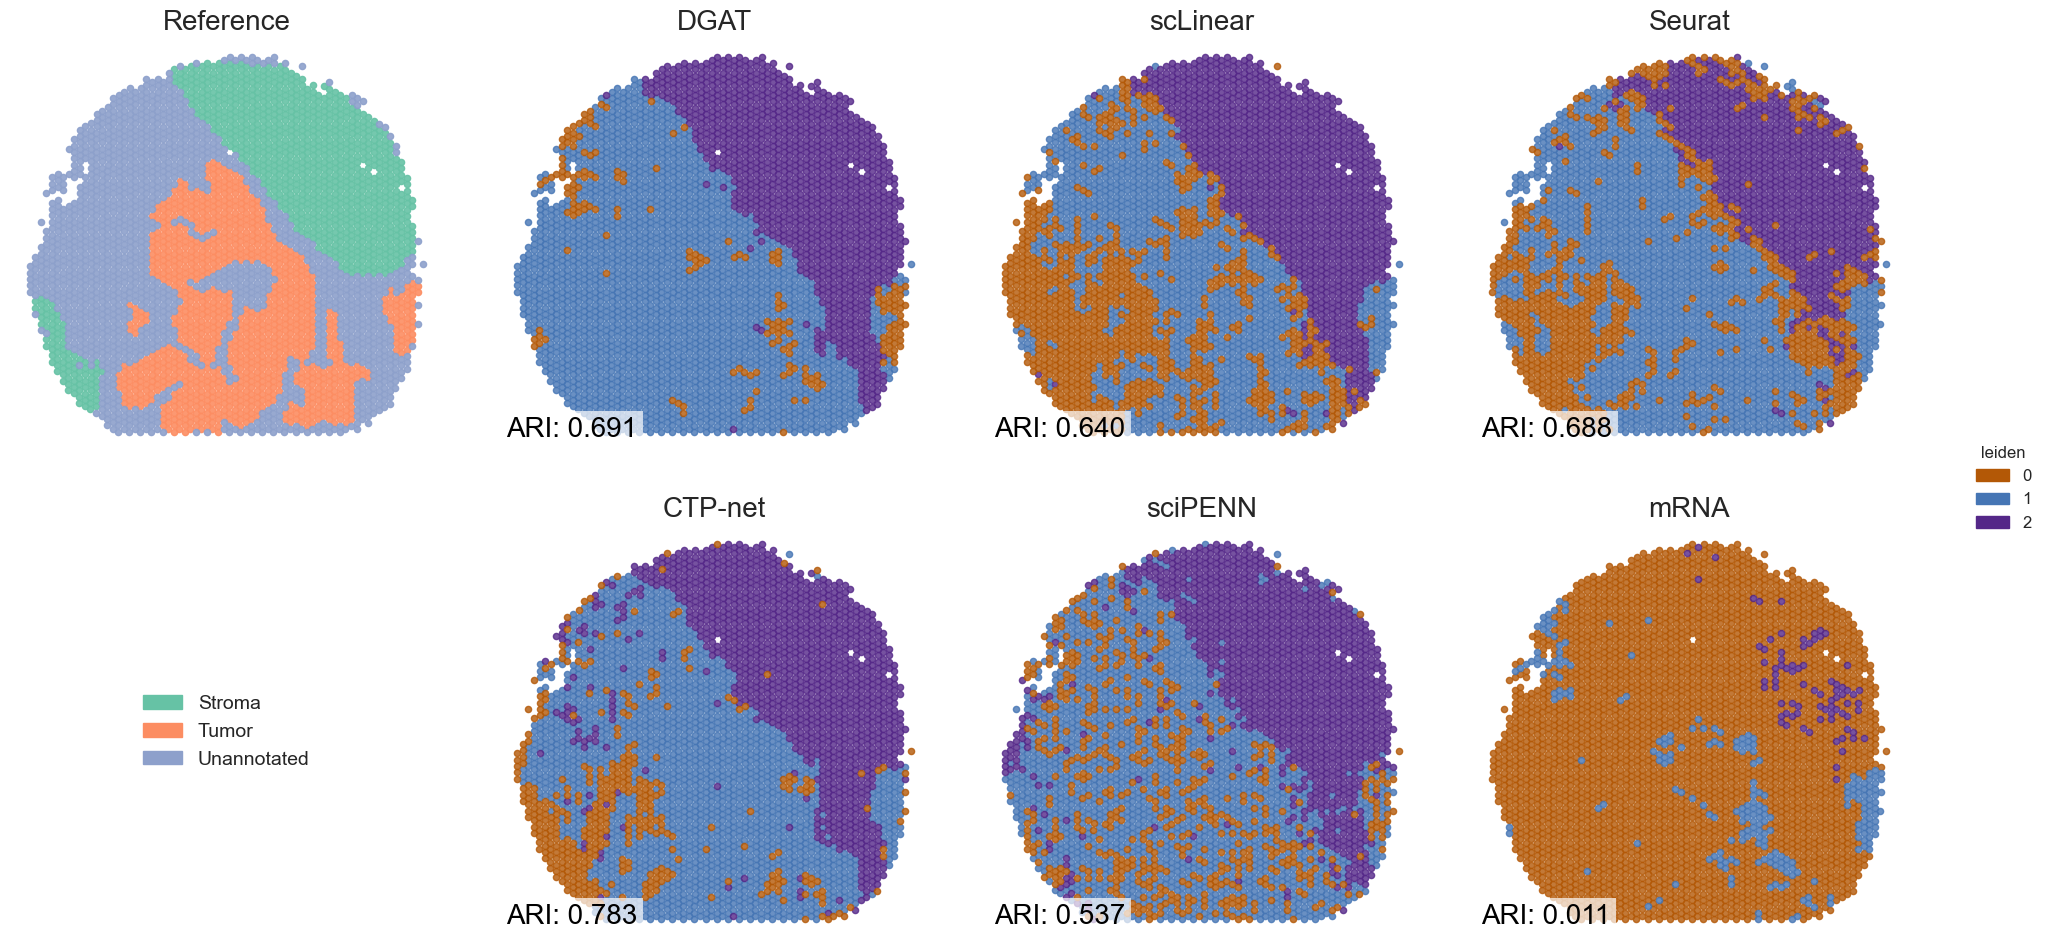

In [41]:
plot_leiden_ARI_scatter_n(
    Ovarian_list,
    palette_list=palette_list,
    method_list=method_list,
    color_key='leiden',
    n_neighbors=10,
    resolution_list=[0.103, 0.07, 0.18, 0.2, 0.04,0.6],
    size=1.7,
    #palette='tab20',
    title='iImpact Ovarian',
    save_fig=True,
    pred_label_key = 'leiden',
    true_label_key = 'annotation',
    None_anno_c = 'Unannotated',
    ref_color = ref_color,
    #test = True,
    figsize=(21, 10),
    dot_size = 20
    
)